In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#path = '/content/drive/MyDrive/Tech Challenge 4/Obesity.csv'

path = '/content/drive/MyDrive/Pós Tech/Tech Challenges/Tech Challenge 4/Ramos/obesity_tratado.parquet'
#df = pd.read_csv(path)

df = pd.read_parquet(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Avaliando e Tratando os dados


In [4]:
# Substituindo gênero
df['gender'] = df['gender'].replace(['Feminino','Masculino'],[0,1])

/tmp/ipython-input-4-1409270993.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender'] = df['gender'].replace(['Feminino','Masculino'],[0,1])


<Axes: >

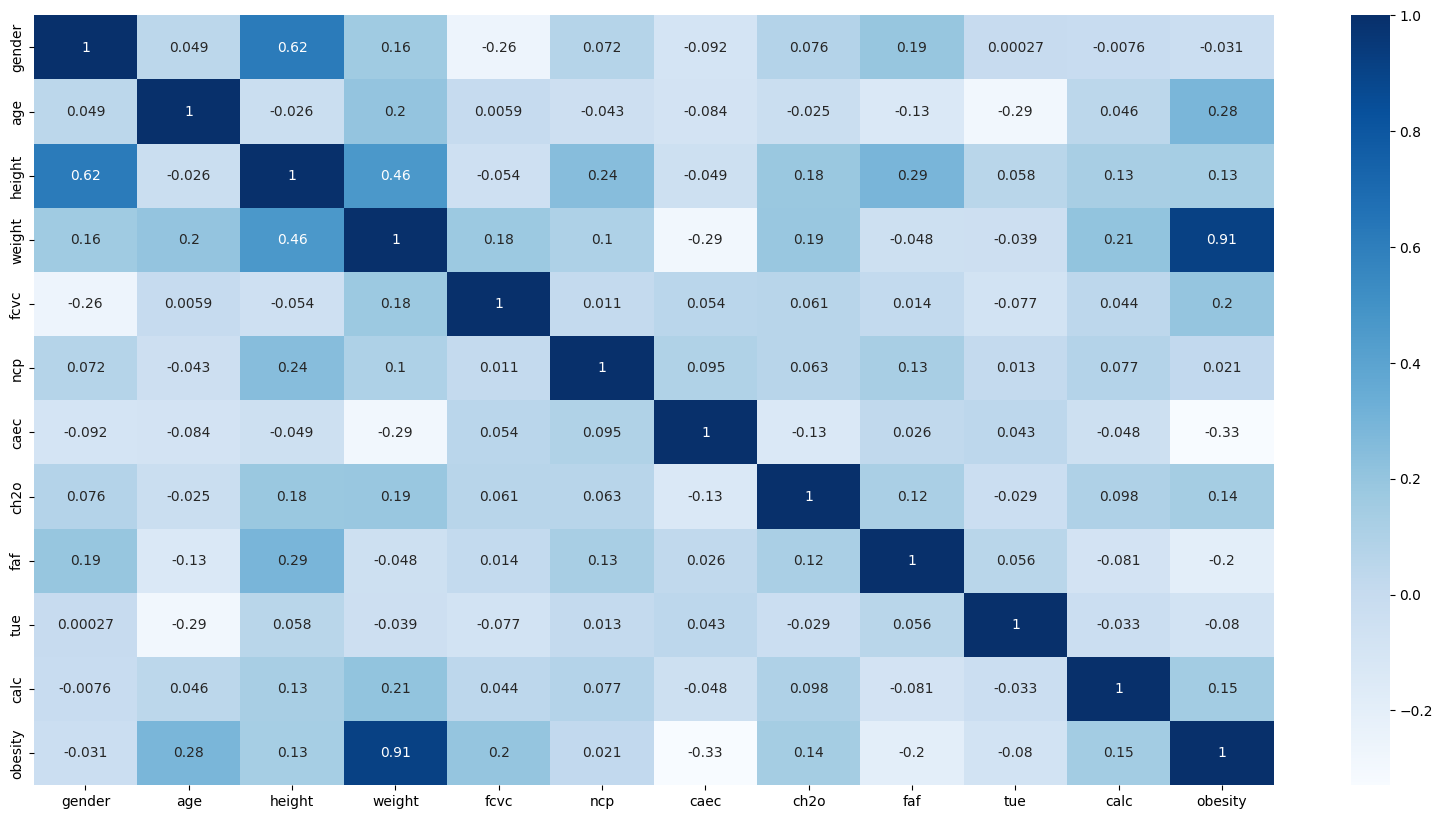

In [5]:
# Criando a matriz de correlação
import matplotlib.pyplot as plt
import seaborn as sns

corr = df.select_dtypes(include='number').corr()
plt.figure(figsize = (20,10))
sns.heatmap(corr, cmap="Blues", annot=True)

In [6]:
# Contar e agrupar pela categoria da coluna obesidade
df['obesity'].groupby(df['obesity']).count()

,obesity
obesity,
0,272
1,287
2,290
3,290
4,351
5,297
6,324


## Tratando a variável target

In [7]:
# Transforma a variável target "Obesity" em apenas duas categorias

'''
def ajusta_variavel_target(cat):
    if cat in [0, 1, 2, 3]:
        return 0
    else:
        return 1

df['obesity'] = df['obesity'].apply(ajusta_variavel_target)
'''

"\ndef ajusta_variavel_target(cat):\n    if cat in [0, 1, 2, 3]:\n        return 0\n    else:\n        return 1\n\ndf['obesity'] = df['obesity'].apply(ajusta_variavel_target)\n"

## Exporta dados para BI

In [8]:
path_gold = '/content/drive/MyDrive/Pós Tech/Tech Challenges/Tech Challenge 4/Ramos/obesity_tratado_todas_classes.csv'
df.to_csv(path_gold, index=False)

## Construindo a Pipeline

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
SEED = 4658751

train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED)

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from imblearn.over_sampling import SMOTE

In [12]:
class DropFeatures(BaseEstimator,TransformerMixin):
    def __init__(self,feature_to_drop = ['weight']):
        self.feature_to_drop = feature_to_drop
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feature_to_drop).issubset(df.columns)):
            df.drop(self.feature_to_drop,axis=1,inplace=True)
            return df
        else:
            print('Uma ou mais features não estão no DataFrame')
            return df

In [13]:
class MinMax(BaseEstimator,TransformerMixin):
    def __init__(self,min_max_scaler  = ['age', 'weight', 'height']):
        self.min_max_scaler = min_max_scaler
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.min_max_scaler).issubset(df.columns)):
            min_max_enc = MinMaxScaler()
            df[self.min_max_scaler] = min_max_enc.fit_transform(df[self.min_max_scaler ])
            return df
        else:
            print('Uma ou mais features não estão no DataFrame')
            return df

In [14]:
class OneHotEncodingNames(BaseEstimator,TransformerMixin):
    def __init__(self,OneHotEncoding = ['mtrans']):

        self.OneHotEncoding = OneHotEncoding

    def fit(self,df):
        return self

    def transform(self,df):
        if (set(self.OneHotEncoding).issubset(df.columns)):
            # função para one-hot-encoding das features
            def one_hot_enc(df,OneHotEncoding):
                one_hot_enc = OneHotEncoder()
                one_hot_enc.fit(df[OneHotEncoding])
                # obtendo o resultado dos nomes das colunas
                feature_names = one_hot_enc.get_feature_names_out(OneHotEncoding)
                # mudando o array do one hot encoding para um dataframe com os nomes das colunas
                df = pd.DataFrame(one_hot_enc.transform(df[self.OneHotEncoding]).toarray(),
                                  columns= feature_names,index=df.index)
                return df

            # função para concatenar as features com aquelas que não passaram pelo one-hot-encoding
            def concat_with_rest(df,one_hot_enc_df,OneHotEncoding):
                # get the rest of the features
                outras_features = [feature for feature in df.columns if feature not in OneHotEncoding]
                # concaternar o restante das features com as features que passaram pelo one-hot-encoding
                df_concat = pd.concat([one_hot_enc_df, df[outras_features]],axis=1)
                return df_concat

            # one hot encoded dataframe
            df_OneHotEncoding = one_hot_enc(df,self.OneHotEncoding)

            # retorna o dataframe concatenado
            df_full = concat_with_rest(df, df_OneHotEncoding,self.OneHotEncoding)
            return df_full

        else:
            print('Uma ou mais features não estão no DataFrame')
            missing = set(self.OneHotEncoding) - set(df.columns)
            print(f"Colunas ausentes no DataFrame: {missing}")
            return df

In [15]:
class OrdinalFeature(BaseEstimator,TransformerMixin):
    def __init__(self,ordinal_feature = ['fcvc','ncp', 'caec', 'ch2o', 'faf', 'tue', 'calc']):
        self.ordinal_feature = ordinal_feature
    def fit(self,df):
        return self
    def transform(self,df):
        for ordinal in self.ordinal_feature:
          if ordinal in df.columns:
              ordinal_encoder = OrdinalEncoder()
              df[self.ordinal_feature] = ordinal_encoder.fit_transform(df[self.ordinal_feature])
              return df
          else:
              print(f"{ordinal} não está no DataFrame")
              return df

In [16]:
class Oversample(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df):
        return self
    def transform(self,df):
        if 'obesity' in df.columns:
            # função smote para superamostrar a classe minoritária para corrigir os dados desbalanceados
            oversample = SMOTE(sampling_strategy='minority')
            X_bal, y_bal = oversample.fit_resample(df.loc[:, df.columns != 'obesity'], df['obesity'])
            df_bal = pd.concat([pd.DataFrame(X_bal),pd.DataFrame(y_bal)],axis=1)
            return df_bal
        else:
            print("O target não está no DataFrame")
            return df

In [17]:
from sklearn.pipeline import Pipeline

In [18]:
'''
def pipeline(df):

    pipeline = Pipeline([
        ('OneHotEncoding', OneHotEncodingNames()),
        ('ordinal_feature', OrdinalFeature()),
        ('min_max_scaler', MinMax()),
        ('oversample', Oversample())
    ])
    df_pipeline = pipeline.fit_transform(df)
    return df_pipeline
'''

"\ndef pipeline(df):\n\n    pipeline = Pipeline([\n        ('OneHotEncoding', OneHotEncodingNames()),\n        ('ordinal_feature', OrdinalFeature()),\n        ('min_max_scaler', MinMax()),\n        ('oversample', Oversample())\n    ])\n    df_pipeline = pipeline.fit_transform(df)\n    return df_pipeline\n"

In [19]:
def pipeline(df):

    pipeline = Pipeline([
        ('OneHotEncoding', OneHotEncodingNames()),
        ('ordinal_feature', OrdinalFeature()),
        ('min_max_scaler', MinMax())
    ])
    df_pipeline = pipeline.fit_transform(df)
    return df_pipeline

## Escolhendo o melhor modelo

In [20]:
train = pipeline(train_df)

In [21]:
train.head()

,mtrans_Automóvel,mtrans_Bicicleta,mtrans_Caminhada,mtrans_Motocicleta,mtrans_Transporte público,gender,age,height,weight,family_history,...,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,obesity
1184,0.0,0.0,0.0,0.0,1.0,1,0.048780,0.665639,0.421042,True,...,1.0,2.0,1.0,False,2.0,False,1.0,1.0,1.0,3
85,0.0,0.0,0.0,0.0,1.0,1,0.195122,0.380472,0.145522,True,...,1.0,2.0,1.0,False,1.0,False,0.0,0.0,0.0,1
749,0.0,0.0,0.0,0.0,1.0,1,0.146341,0.318586,0.222909,False,...,0.0,2.0,0.0,False,1.0,False,1.0,0.0,1.0,2
1374,0.0,0.0,0.0,0.0,1.0,1,0.268293,0.723627,0.496114,True,...,2.0,2.0,1.0,False,1.0,False,2.0,2.0,1.0,4
1341,0.0,0.0,0.0,0.0,1.0,1,0.146341,0.647129,0.492852,True,...,1.0,2.0,1.0,False,0.0,False,0.0,0.0,1.0,4


In [22]:
X_train, y_train = train.loc[:, train.columns != 'obesity'], train['obesity']

In [23]:
test = pipeline(test_df)

In [24]:
test.head()

,mtrans_Automóvel,mtrans_Bicicleta,mtrans_Caminhada,mtrans_Motocicleta,mtrans_Transporte público,gender,age,height,weight,family_history,...,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,obesity
1283,0.0,0.0,0.0,0.0,1.0,0,0.340426,0.100822,0.330873,True,...,1.0,1.0,1.0,False,1.0,False,0.0,0.0,0.0,4
466,1.0,0.0,0.0,0.0,0.0,1,0.170213,0.516827,0.304611,True,...,2.0,2.0,2.0,False,0.0,False,1.0,0.0,0.0,1
391,0.0,0.0,1.0,0.0,0.0,0,0.085106,0.436298,0.087959,False,...,1.0,2.0,1.0,False,1.0,False,0.0,1.0,1.0,0
1732,1.0,0.0,0.0,0.0,0.0,1,0.382979,0.572160,0.695954,True,...,2.0,2.0,1.0,False,1.0,False,1.0,0.0,1.0,5
645,0.0,0.0,0.0,0.0,1.0,0,0.148936,0.572148,0.142261,True,...,1.0,3.0,2.0,False,1.0,False,2.0,1.0,0.0,0


In [25]:
X_test, y_test= test.loc[:, test.columns != 'obesity'], test['obesity']

In [26]:
from sklearn import metrics
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
import numpy as np

In [27]:
SEED = 4658751
'''
def roda_modelo(modelo):


    # Treinando modelo com os dados de treino

    modelo.fit(X_train, y_train)

    # Calculando a probabilidade e calculando o AUC
    prob_predic = modelo.predict_proba(X_test)

    print(f"\n------------------------------Resultados {modelo}------------------------------\n")

    auc = roc_auc_score(y_test, prob_predic[:,1])
    print(f"AUC {auc}")

    # Separando a probabilidade de ser bom e mau, e calculando o KS
    #métrica KS: probabilidade de um cliente ser classificado como bom ou mau.
    data_nao_obeso = np.sort(modelo.predict_proba(X_test)[:, 0])
    data_obeso = np.sort(modelo.predict_proba(X_test)[:, 1])
    kstest = stats.ks_2samp(data_nao_obeso, data_obeso)

    print(f"Métrica KS: {kstest}")

    print("\nConfusion Matrix\n")
    # Criando matriz de confusão
    fig, ax = plt.subplots(figsize=(7,7))
    matriz_confusao = ConfusionMatrixDisplay.from_estimator(modelo, X_test, y_test, normalize='true',
                                            display_labels=['Não Obeso', 'Obeso'],
                                            ax=ax, cmap=plt.cm.Blues)
    ax.set_title("Matriz de Confusão\n Normalizada", fontsize=16, fontweight="bold")
    ax.set_xlabel("Label predita", fontsize=18)
    ax.set_ylabel("Label verdadeira", fontsize=18)
    plt.grid(False)
    plt.show(matriz_confusao)

    # Fazendo a predicao dos dados de teste e calculando o classification report
    predicao = modelo.predict(X_test)
    print("\nClassification Report")
    print(classification_report(y_test, predicao, zero_division=0))


    print("\nRoc Curve\n")
    metrics.RocCurveDisplay.from_estimator(modelo, X_test, y_test)
  '''

'\ndef roda_modelo(modelo):\n\n\n    # Treinando modelo com os dados de treino\n\n    modelo.fit(X_train, y_train)\n\n    # Calculando a probabilidade e calculando o AUC\n    prob_predic = modelo.predict_proba(X_test)\n\n    print(f"\n------------------------------Resultados {modelo}------------------------------\n")\n\n    auc = roc_auc_score(y_test, prob_predic[:,1])\n    print(f"AUC {auc}")\n\n    # Separando a probabilidade de ser bom e mau, e calculando o KS\n    #métrica KS: probabilidade de um cliente ser classificado como bom ou mau.\n    data_nao_obeso = np.sort(modelo.predict_proba(X_test)[:, 0])\n    data_obeso = np.sort(modelo.predict_proba(X_test)[:, 1])\n    kstest = stats.ks_2samp(data_nao_obeso, data_obeso)\n\n    print(f"Métrica KS: {kstest}")\n\n    print("\nConfusion Matrix\n")\n    # Criando matriz de confusão\n    fig, ax = plt.subplots(figsize=(7,7))\n    matriz_confusao = ConfusionMatrixDisplay.from_estimator(modelo, X_test, y_test, normalize=\'true\',\n         

In [28]:
SEED = 4658751

def roda_modelo(modelo):
    # Treinando modelo
    modelo.fit(X_train, y_train)

    print(f"\n------------------------------Resultados {modelo}------------------------------\n")

    # Calculando probabilidades
    prob_predic = modelo.predict_proba(X_test)

    # AUC Multiclasse
    try:
        auc = roc_auc_score(y_test, prob_predic, multi_class='ovr')  # ou 'ovo'
        print(f"AUC Multiclasse (OvR): {auc:.4f}")
    except Exception as e:
        print(f"Erro ao calcular AUC: {e}")

    # KS por classe (classe vs resto)
    print("\nMétrica KS por classe:\n")
    for i in range(7):  # 0 a 6 para 7 classes
        classe_probs = prob_predic[:, i]
        resto_probs = prob_predic[:, [j for j in range(7) if j != i]].mean(axis=1)
        kstest = stats.ks_2samp(classe_probs, resto_probs)
        print(f"KS Classe {i + 1} vs Resto: estatística={kstest.statistic:.4f}, p-valor={kstest.pvalue:.4f}")

    # Matriz de confusão
    print("\nMatriz de Confusão\n")
    fig, ax = plt.subplots(figsize=(8,8))
    ConfusionMatrixDisplay.from_estimator(
        modelo, X_test, y_test,
        normalize='true',
        ax=ax,
        cmap=plt.cm.Blues
    )
    ax.set_title("Matriz de Confusão Normalizada", fontsize=16, fontweight="bold")
    ax.set_xlabel("Label predita", fontsize=14)
    ax.set_ylabel("Label verdadeira", fontsize=14)
    plt.grid(False)
    plt.show()

    # Classification report
    predicao = modelo.predict(X_test)
    print("\nClassification Report\n")
    print(classification_report(y_test, predicao, zero_division=0))

In [29]:
def predict_obesity(modelo, values):
  predicao = modelo.predict(values)
  return predicao

In [30]:
from sklearn.linear_model import LogisticRegression
modelo_logistico = LogisticRegression()


------------------------------Resultados LogisticRegression()------------------------------

AUC Multiclasse (OvR): 0.9446

Métrica KS por classe:

KS Classe 1 vs Resto: estatística=0.6596, p-valor=0.0000
KS Classe 2 vs Resto: estatística=0.5390, p-valor=0.0000
KS Classe 3 vs Resto: estatística=0.5768, p-valor=0.0000
KS Classe 4 vs Resto: estatística=0.5626, p-valor=0.0000
KS Classe 5 vs Resto: estatística=0.4232, p-valor=0.0000
KS Classe 6 vs Resto: estatística=0.5343, p-valor=0.0000
KS Classe 7 vs Resto: estatística=0.6809, p-valor=0.0000

Matriz de Confusão



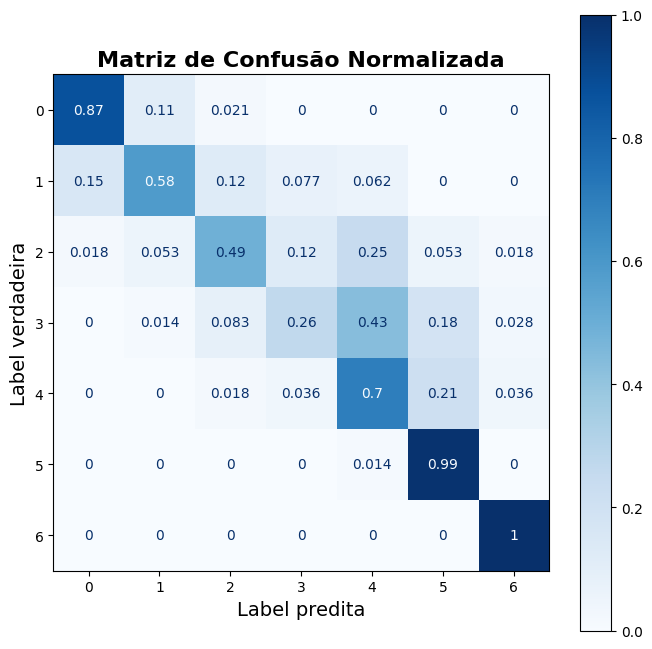


Classification Report

              precision    recall  f1-score   support

           0       0.79      0.87      0.83        47
           1       0.81      0.58      0.68        65
           2       0.64      0.49      0.55        57
           3       0.58      0.26      0.36        72
           4       0.44      0.70      0.54        56
           5       0.71      0.99      0.82        69
           6       0.92      1.00      0.96        57

    accuracy                           0.69       423
   macro avg       0.70      0.70      0.68       423
weighted avg       0.69      0.69      0.67       423



In [31]:
roda_modelo(modelo_logistico)

In [32]:
from sklearn.tree import DecisionTreeClassifier
modelo_tree = DecisionTreeClassifier()


------------------------------Resultados DecisionTreeClassifier()------------------------------

AUC Multiclasse (OvR): 0.8090

Métrica KS por classe:

KS Classe 1 vs Resto: estatística=0.8251, p-valor=0.0000
KS Classe 2 vs Resto: estatística=0.7778, p-valor=0.0000
KS Classe 3 vs Resto: estatística=0.8251, p-valor=0.0000
KS Classe 4 vs Resto: estatística=0.6738, p-valor=0.0000
KS Classe 5 vs Resto: estatística=0.5461, p-valor=0.0000
KS Classe 6 vs Resto: estatística=0.6265, p-valor=0.0000
KS Classe 7 vs Resto: estatística=0.7258, p-valor=0.0000

Matriz de Confusão



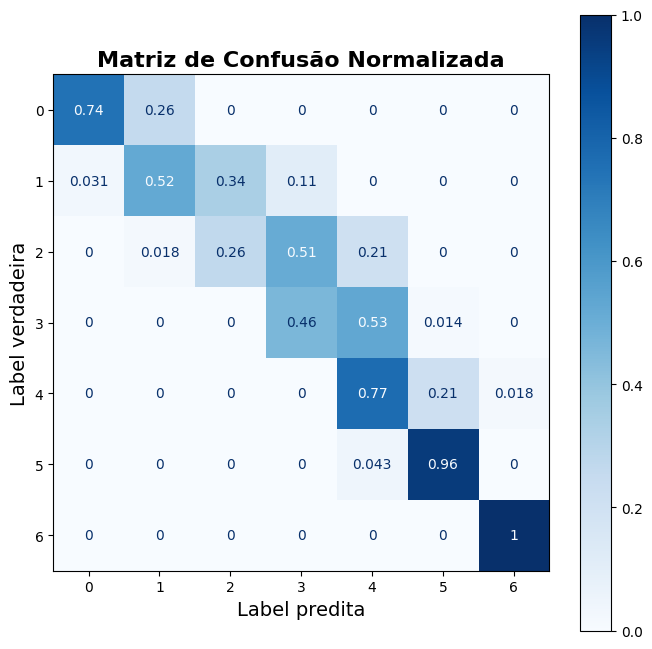


Classification Report

              precision    recall  f1-score   support

           0       0.95      0.74      0.83        47
           1       0.72      0.52      0.61        65
           2       0.41      0.26      0.32        57
           3       0.48      0.46      0.47        72
           4       0.45      0.77      0.57        56
           5       0.84      0.96      0.89        69
           6       0.98      1.00      0.99        57

    accuracy                           0.67       423
   macro avg       0.69      0.67      0.67       423
weighted avg       0.68      0.67      0.66       423



In [33]:
roda_modelo(modelo_tree)

In [34]:
from sklearn.ensemble import RandomForestClassifier
modelo_forest = RandomForestClassifier()


------------------------------Resultados RandomForestClassifier()------------------------------

AUC Multiclasse (OvR): 0.9879

Métrica KS por classe:

KS Classe 1 vs Resto: estatística=0.7092, p-valor=0.0000
KS Classe 2 vs Resto: estatística=0.5910, p-valor=0.0000
KS Classe 3 vs Resto: estatística=0.6217, p-valor=0.0000
KS Classe 4 vs Resto: estatística=0.5390, p-valor=0.0000
KS Classe 5 vs Resto: estatística=0.4279, p-valor=0.0000
KS Classe 6 vs Resto: estatística=0.6076, p-valor=0.0000
KS Classe 7 vs Resto: estatística=0.7139, p-valor=0.0000

Matriz de Confusão



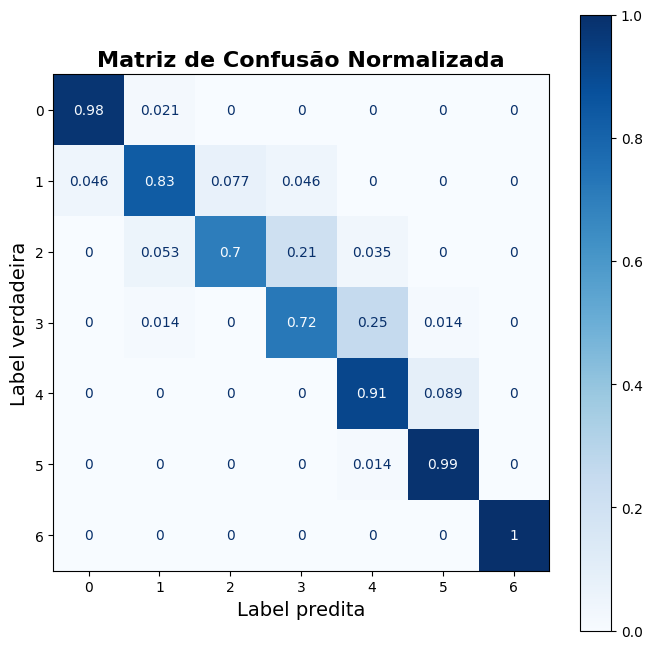


Classification Report

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        47
           1       0.92      0.83      0.87        65
           2       0.89      0.70      0.78        57
           3       0.78      0.72      0.75        72
           4       0.71      0.91      0.80        56
           5       0.92      0.99      0.95        69
           6       1.00      1.00      1.00        57

    accuracy                           0.87       423
   macro avg       0.88      0.88      0.87       423
weighted avg       0.88      0.87      0.87       423



In [35]:
roda_modelo(modelo_forest)

In [36]:
from sklearn.ensemble import GradientBoostingClassifier
modelo_xgb = GradientBoostingClassifier()


------------------------------Resultados GradientBoostingClassifier()------------------------------

AUC Multiclasse (OvR): 0.9576

Métrica KS por classe:

KS Classe 1 vs Resto: estatística=0.7967, p-valor=0.0000
KS Classe 2 vs Resto: estatística=0.7447, p-valor=0.0000
KS Classe 3 vs Resto: estatística=0.7187, p-valor=0.0000
KS Classe 4 vs Resto: estatística=0.6501, p-valor=0.0000
KS Classe 5 vs Resto: estatística=0.5366, p-valor=0.0000
KS Classe 6 vs Resto: estatística=0.6241, p-valor=0.0000
KS Classe 7 vs Resto: estatística=0.7305, p-valor=0.0000

Matriz de Confusão



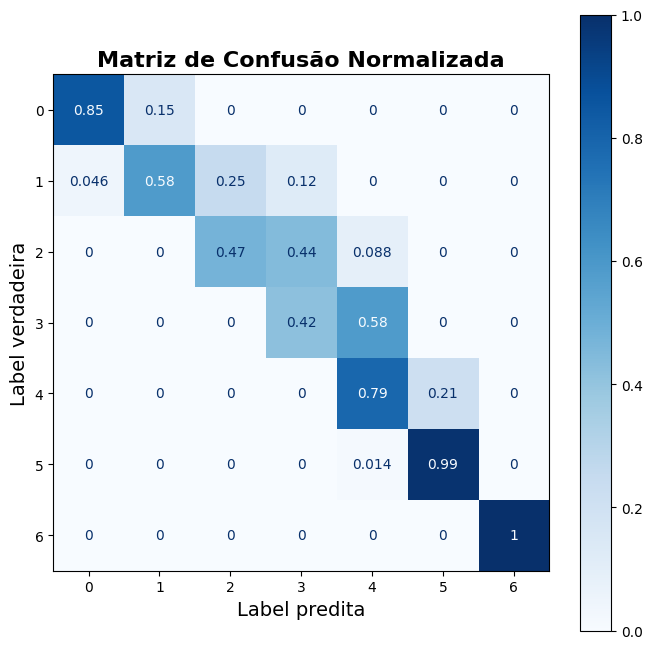


Classification Report

              precision    recall  f1-score   support

           0       0.93      0.85      0.89        47
           1       0.84      0.58      0.69        65
           2       0.63      0.47      0.54        57
           3       0.48      0.42      0.44        72
           4       0.48      0.79      0.59        56
           5       0.85      0.99      0.91        69
           6       1.00      1.00      1.00        57

    accuracy                           0.72       423
   macro avg       0.74      0.73      0.72       423
weighted avg       0.74      0.72      0.72       423



In [37]:
roda_modelo(modelo_xgb)

In [38]:
import joblib

In [39]:
joblib.dump(modelo_forest, 'forest.joblib')

['forest.joblib']